In [1]:
from bread.algo.lineage.nn._model import LineageClassifierLogistic
from bread.algo.lineage.nn.preprocess import FEATURE_NAMES
import torch
import matplotlib.pyplot as plt
import numpy as np

/home/nicole/.miniconda3/envs/bread/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logistic_model = LineageClassifierLogistic.load_from_checkpoint('../../data/generated/pytorch/best/logistic.demo.ckpt')

In [3]:
logistic_model

LineageClassifierLogistic(
  (loss): BCEWithLogitsLoss()
  (layers): Sequential(
    (0): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [4]:
logistic_model.hparams

"batch_size":    5000
"class_weights": [0.02409336157143116, 0.9759066104888916]
"dropout":       0.1
"frac_train":    0.9
"frac_val":      0.1
"input_dim":     25
"lr":            0.0001
"lr_decay":      0.97
"num_epochs":    400
"num_hidden":    2
"seed":          0
"size_hidden":   128

## Verify BatchNorm1d has a good estimate for statistics

-- OK

In [5]:
data = torch.load('../../data/lineage_nn/data_train.pt')['data'] + torch.load('../../data/lineage_nn/data_test.pt')['data']
x = torch.cat([ d['x'] for d in data ], dim=0)
y = torch.cat([ d['y'] for d in data ])  # is_budding

In [6]:
print(x.mean(dim=0))
print(logistic_model.layers[0].running_mean)

tensor([ 2.3526e+01,  2.6356e+00,  5.2028e-01, -9.3666e-03,  6.5544e-01,
         1.5827e+00,  2.3526e+01,  2.6356e+00,  5.2028e-01, -9.3666e-03,
         6.5544e-01,  1.5827e+00,  7.0491e-01,  7.4491e-01,  7.9274e-01,
         2.7924e-01,  1.3714e-02,  1.9511e-09, -9.7554e-10,  5.3859e+00,
         1.3086e-02, -5.4277e-03, -3.3770e-03,  2.5041e+00,  2.2756e-02])
tensor([ 2.3790e+01,  2.6415e+00,  5.2099e-01, -4.5787e-02,  6.4654e-01,
         1.6255e+00,  2.3768e+01,  2.6415e+00,  5.2053e-01, -4.5445e-02,
         6.4705e-01,  1.6254e+00,  7.0828e-01,  7.4508e-01,  7.9312e-01,
         2.7890e-01,  1.5022e-02,  7.0383e-03, -8.6254e-03,  5.4000e+00,
         6.9376e-03, -3.5950e-03, -6.1628e-03,  2.5115e+00,  2.2532e-02])


In [7]:
print(x.std(dim=0))
print(logistic_model.layers[0].running_var.sqrt())

tensor([15.1882,  0.7883,  0.1352,  0.6904,  0.3060,  0.8823, 15.1882,  0.7883,
         0.1352,  0.6904,  0.3060,  0.8823,  0.4528,  0.4738,  0.4748,  0.1199,
         0.0640,  3.9050,  3.8988,  1.2007,  1.8180,  1.8650,  1.8703,  0.8400,
         1.8141])
tensor([16.3075,  0.8211,  0.1395,  0.6966,  0.3078,  0.8925, 16.1323,  0.8170,
         0.1398,  0.6961,  0.3077,  0.8919,  0.4507,  0.4749,  0.4750,  0.1215,
         0.0734,  3.9159,  3.9268,  1.2624,  1.8158,  1.8811,  1.8778,  0.8700,
         1.8135])


## Check the weights of the logistic model

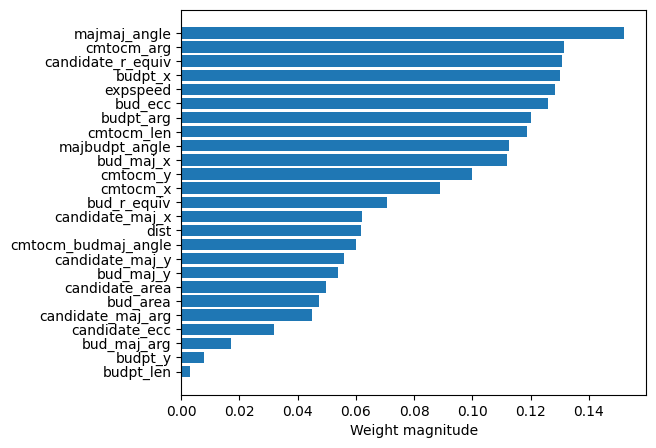

In [8]:
fig, ax = plt.subplots(figsize=(6, 5))

weights_mag = np.abs(logistic_model.layers[1].weight.detach().numpy().squeeze())
i_sorted = np.argsort(weights_mag)
idx = np.arange(len(weights_mag))

ax.barh(idx, np.abs(weights_mag[i_sorted]))
ax.set_yticks(idx)
ax.set_yticklabels(np.array(FEATURE_NAMES)[i_sorted])
ax.set_xlabel('Weight magnitude')

plt.show()

Selected features :
- majmaj angle : different distribution shapes (but still some overlap)
- cmtocm arg : distrib is uniform. probably combined with other features ?
- candidate r equiv : real parents tend to be larger
- expspeed : two distinct sharp distributions
- ...

See `statistics.ipynb` : the separation boundary is nonlinear, and theere is little overlap, so logistic regression won't work well